# Tobigs 21기 4주차 정규세션 Ensemble
## LG Aimers 해커톤 - 영업 성공 여부 분류 경진대회
- 고객의 다양한 정보를 보고 해당 고객이 전환 고객인지 아닌지를 판단하는 모델을 구현
- train.csv - 고객의 다양한 정보를 기록한 데이터와 해당 고객의 영업이 성공으로 전환되었는지 알려주는 라벨 데이터로 이루어져 있음.
- target value는 submission.csv의 "is_converted".
------------------------------------------------
### 과제목표: 앙상블 모델 최소 2가지를 이용해 코드를 짜주세요!


##데이터 확인

### 필수 라이브러리

In [28]:
!pip install catboost --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.5 MB/s eta 0:00:00


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.0 MB/s eta 0:00:00


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### 데이터 셋 읽어오기

In [2]:
#드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [39]:
df_train = pd.read_csv("/content/drive/MyDrive/Contest/LG_aimers_4_Hackathon/train.csv") #학습용 데이터
df_test = pd.read_csv("/content/drive/MyDrive/Contest/LG_aimers_4_Hackathon/submission.csv") #테스트 데이터(제출파일의 데이터)

##EDA

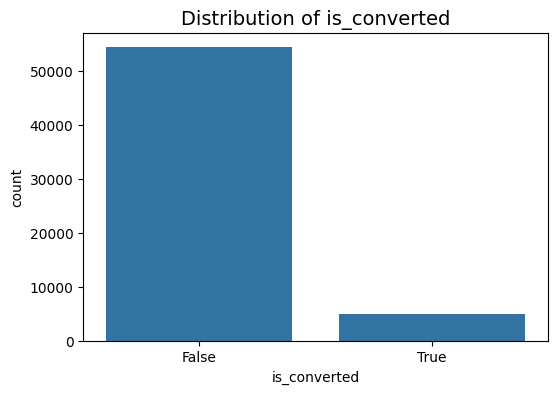

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
sns.countplot(x='is_converted', data=df_train)
plt.title('Distribution of is_converted', fontsize=14)
plt.show()

#타겟 변수의 클래스 불균형 문제 확인

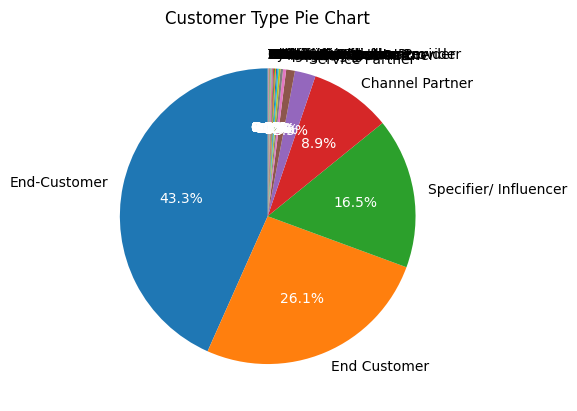

In [41]:
#customer type컬럼의 값의 빈도수 확인
customer_type_counts = df_train['customer_type'].value_counts()

#Pie chart
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(customer_type_counts, labels=customer_type_counts.index, autopct='%1.1f%%', startangle=90)

for autotext in autotexts:
    autotext.set_color('white')

plt.title('Customer Type Pie Chart')

plt.show()

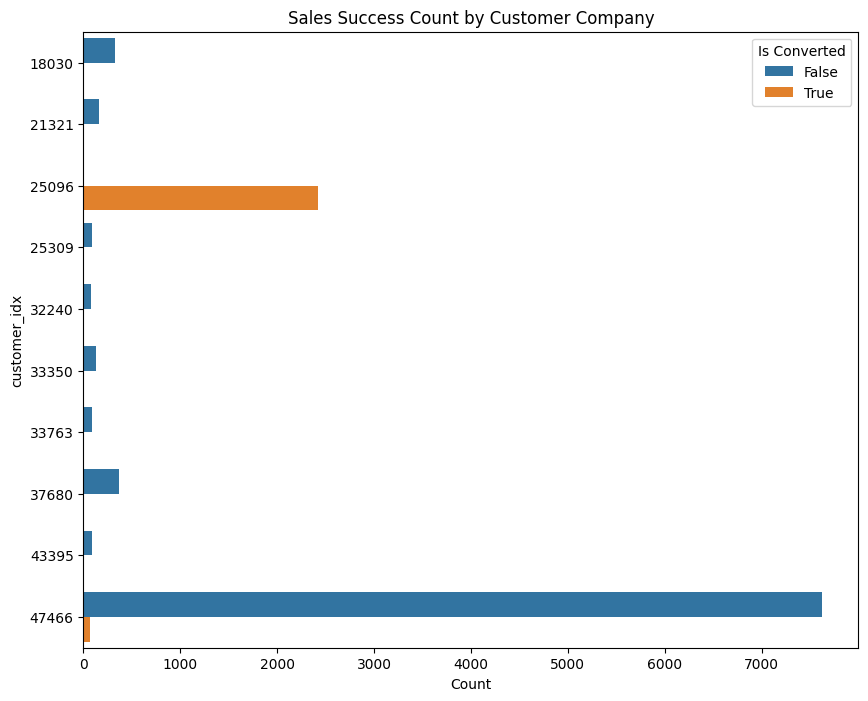

In [42]:
#고객의 회사명과 타겟 변수와 관계 확인
N = 10
top_companies = df_train['customer_idx'].value_counts().head(N).index

# 상위 N개 회사에 해당하는 데이터만 필터링
filtered_df = df_train[df_train['customer_idx'].isin(top_companies)]

# 카운트 플롯 그리기
plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_df, y='customer_idx', hue='is_converted')
plt.title('Sales Success Count by Customer Company')
plt.xlabel('Count')
plt.ylabel('customer_idx')
plt.legend(title='Is Converted', loc='upper right')
plt.show()

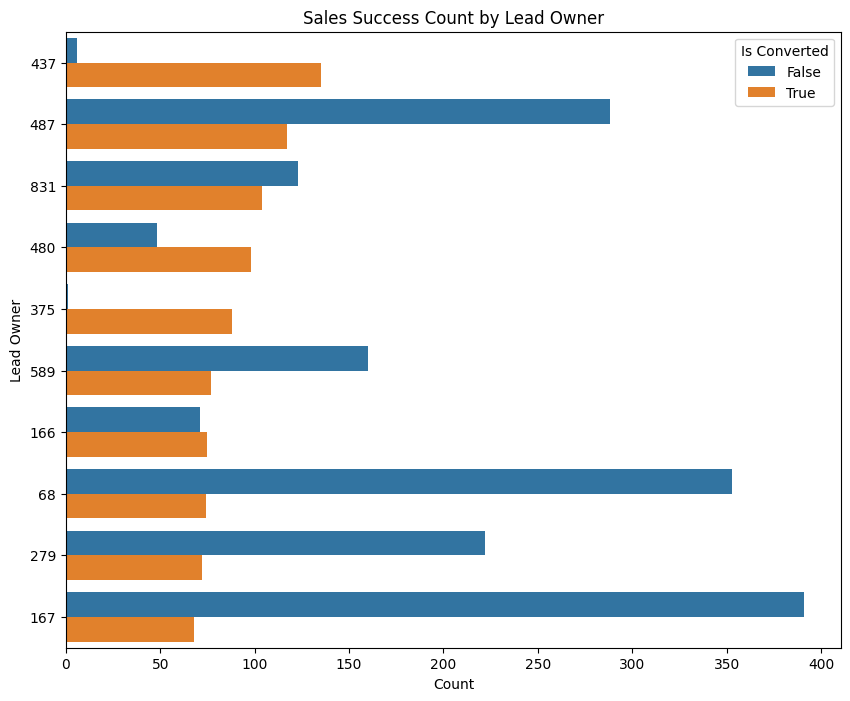

In [43]:
#is_converted가 True인 경우
success_df = df_train[df_train['is_converted'] == True]
success_counts = success_df['lead_owner'].value_counts()

N = 10
top_lead_owners = success_counts.head(N).index

#상위 N개 lead_owner에 해당하는 데이터만 필터링
filtered_df = df_train[df_train['lead_owner'].isin(top_lead_owners)]

#카운트 플롯 그리기 - 성공 여부가 많은 순으로
plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_df, y='lead_owner', hue='is_converted', order=top_lead_owners)
plt.title('Sales Success Count by Lead Owner')
plt.xlabel('Count')
plt.ylabel('Lead Owner')
plt.legend(title='Is Converted', loc='upper right')
plt.show()

In [44]:
#고객 국가 전처리
import re

def preprocess_data(df):
    #고객 국가 컬럼 합치기
    if 'customer_country.1' in df.columns:
        df['customer_country'] = df['customer_country'].fillna(df['customer_country.1'])
        df = df.drop(columns=['customer_country.1'])

    df = df.drop_duplicates()

    #customer_country의 국가만 추출 및 문자열 정리
    df['customer_country'] = df['customer_country'].apply(lambda x: x.split('/')[-1].strip().lower().capitalize() if pd.notnull(x) else x)

    #이메일, 숫자, 특수 문자가 포함된 경우 삭제
    df = df[~df['customer_country'].apply(lambda x: bool(re.search(r'\d|@|\.', x)) if pd.notnull(x) else False)]

    #고유한 값 확인
    unique_customer_countries = df['customer_country'].unique()
    num_unique_countries = len(unique_customer_countries)
    print(f"Number of unique customer countries: {num_unique_countries}")
    print("Sample of unique customer countries:", unique_customer_countries[:10])

    return df

#중복 국가 처리
df_train['customer_country'] = df_train['customer_country'].replace('Türkiye', 'Turkey')
df_test['customer_country'] = df_test['customer_country'].replace('Türkiye', 'Turkey')

df_train = preprocess_data(df_train)
df_test = preprocess_data(df_test)

Number of unique customer countries: 242
Sample of unique customer countries: ['Philippines' 'India' 'Nigeria' 'Saudi arabia' 'Singapore' 'Brazil'
 'South africa' 'United states' 'Colombia' 'Mexico']
Number of unique customer countries: 95
Sample of unique customer countries: ['Brazil' 'United states' 'Germany' 'Egypt' 'France' '' 'Indonesia'
 'India' 'Italy' 'Argentina']


In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53938 entries, 0 to 59298
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bant_submit              53938 non-null  float64
 1   customer_country         52964 non-null  object 
 2   business_unit            53938 non-null  object 
 3   com_reg_ver_win_rate     13611 non-null  float64
 4   customer_idx             53938 non-null  int64  
 5   customer_type            13939 non-null  object 
 6   enterprise               53938 non-null  object 
 7   historical_existing_cnt  11996 non-null  float64
 8   id_strategic_ver         3201 non-null   float64
 9   it_strategic_ver         1090 non-null   float64
 10  idit_strategic_ver       4291 non-null   float64
 11  customer_job             37805 non-null  object 
 12  lead_desc_length         53938 non-null  int64  
 13  inquiry_type             53054 non-null  object 
 14  product_category      

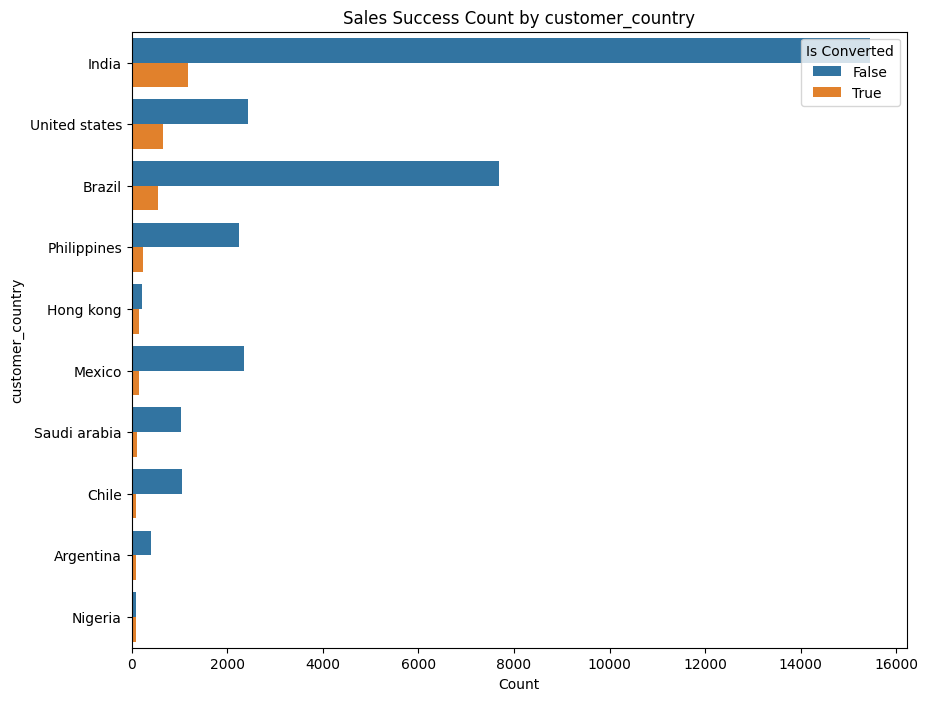

In [46]:
success_df = df_train[df_train['is_converted'] == True]
success_counts = success_df['customer_country'].value_counts()

N = 10
top_lead_owners = success_counts.head(N).index

filtered_df = df_train[df_train['customer_country'].isin(top_lead_owners)]

# 카운트 플롯 그리기 - 성공 여부가 많은 순으로
plt.figure(figsize=(10, 8))
sns.countplot(data=filtered_df, y='customer_country', hue='is_converted', order=top_lead_owners)
plt.title('Sales Success Count by customer_country')
plt.xlabel('Count')
plt.ylabel('customer_country')
plt.legend(title='Is Converted', loc='upper right')
plt.show()

In [47]:
#범주형 수치형 나누기
categorical_cols = df_train.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_cols = df_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

categorical_cols, numerical_cols

(['customer_country',
  'business_unit',
  'customer_type',
  'enterprise',
  'customer_job',
  'inquiry_type',
  'product_category',
  'product_subcategory',
  'product_modelname',
  'customer_position',
  'response_corporate',
  'expected_timeline',
  'business_area',
  'business_subarea',
  'is_converted'],
 ['bant_submit',
  'com_reg_ver_win_rate',
  'customer_idx',
  'historical_existing_cnt',
  'id_strategic_ver',
  'it_strategic_ver',
  'idit_strategic_ver',
  'lead_desc_length',
  'ver_cus',
  'ver_pro',
  'ver_win_rate_x',
  'ver_win_ratio_per_bu',
  'lead_owner'])

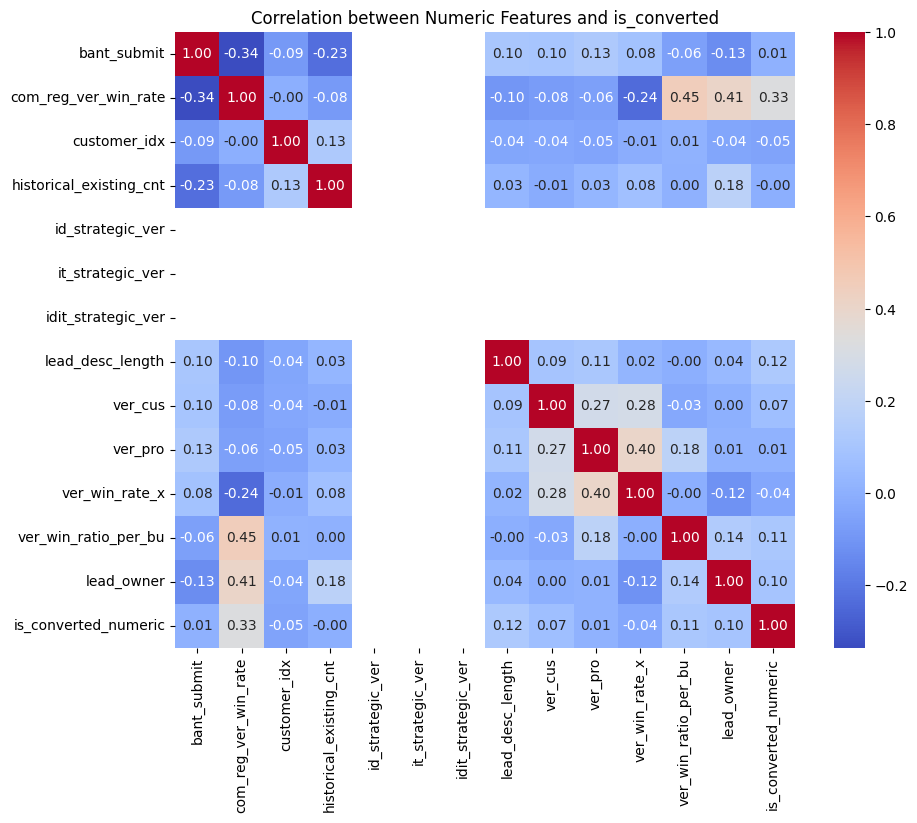

In [48]:
#타겟과 상관 관계 확인

#타겟 변수를 수치형으로 변환
df_train['is_converted_numeric'] = df_train['is_converted'].astype(int)

#수치형 변수와 'is_converted' 사이의 상관 관계 분석
correlations = df_train[numerical_cols + ['is_converted_numeric']].corr()

#상관 관계 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlations, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Numeric Features and is_converted')
plt.show()

In [49]:
df_train = df_train.drop(labels=['is_converted_numeric'],axis=1)

## 2. 데이터 전처리

In [50]:
#train 결측치 비율 확인
missing_percentage = (df_train.isnull().sum() / len(df_train) * 100).sort_values(ascending= False)
missing_percentage

it_strategic_ver           97.979161
id_strategic_ver           94.065408
idit_strategic_ver         92.044570
business_subarea           90.724536
product_subcategory        84.161445
product_modelname          84.002002
historical_existing_cnt    77.759650
com_reg_ver_win_rate       74.765471
customer_type              74.157366
ver_win_ratio_per_bu       73.337906
ver_win_rate_x             68.161593
business_area              68.161593
expected_timeline          50.496867
product_category           31.046757
customer_job               29.910267
customer_country            1.805777
inquiry_type                1.638919
ver_cus                     0.000000
lead_owner                  0.000000
ver_pro                     0.000000
bant_submit                 0.000000
response_corporate          0.000000
customer_position           0.000000
lead_desc_length            0.000000
enterprise                  0.000000
customer_idx                0.000000
business_unit               0.000000
i

In [51]:
#결측치 비율 80% 이상 컬럼 드랍
columns_to_drop = missing_percentage[missing_percentage > 80].index

df_train = df_train.drop(columns=columns_to_drop)

In [52]:
#df_train에서 데이터 타입이 object인 컬럼들만 선택
object_columns = df_train.select_dtypes(include='object').columns

#선택된 컬럼 출력
print(object_columns)

Index(['customer_country', 'business_unit', 'customer_type', 'enterprise',
       'customer_job', 'inquiry_type', 'product_category', 'customer_position',
       'response_corporate', 'expected_timeline', 'business_area'],
      dtype='object')


In [53]:
#결측치 0으로
df_test = df_test.fillna(0)
df_train = df_train.fillna(0)

In [54]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#수치형 변수만 선택
train_numerical_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
test_numerical_cols = df_test.select_dtypes(include=['float64', 'int64']).columns

#Scaler
scaler = MinMaxScaler()

#caling 수행
train_scaled = df_train.copy()
test_scaled = df_test.copy()

train_scaled[train_numerical_cols] = scaler.fit_transform(df_train[train_numerical_cols])
test_scaled[test_numerical_cols] = scaler.fit_transform(df_test[test_numerical_cols])


print(train_scaled.head())
print("==================")
print(test_scaled.head())

   bant_submit customer_country business_unit  com_reg_ver_win_rate  \
0          1.0      Philippines            AS              0.066667   
1          1.0      Philippines            AS              0.066667   
2          1.0            India            AS              0.088889   
3          1.0            India            AS              0.088889   
4          1.0            India            AS              0.088889   

   customer_idx          customer_type  enterprise  historical_existing_cnt  \
0      0.677524           End-Customer  Enterprise                 0.000000   
1      0.487106           End-Customer  Enterprise                 0.008608   
2      0.036933           End-Customer  Enterprise                 0.103300   
3      0.103594           End-Customer  Enterprise                 0.000000   
4      0.360779  Specifier/ Influencer  Enterprise                 0.000000   

              customer_job  lead_desc_length  ... customer_position  \
0               purchasing 

### 레이블 인코딩

In [55]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [56]:
# df_train에서 데이터 타입이 object인 컬럼들만 선택
object_columns = df_train.select_dtypes(include='object').columns

# 선택된 컬럼 출력
print(object_columns)

Index(['customer_country', 'business_unit', 'customer_type', 'enterprise',
       'customer_job', 'inquiry_type', 'product_category', 'customer_position',
       'response_corporate', 'expected_timeline', 'business_area'],
      dtype='object')


In [57]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    #"business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    #"product_subcategory",
    #"product_modelname",
    #"customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [58]:
for col in label_columns:
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

###학습, 검증 데이터 분리

In [59]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.3,
    shuffle=True,
    stratify=df_train["is_converted"],  #타겟 변수의 imbalance를 고려해서 추가
    random_state=400
)

#분할된 데이터의 타겟 분포 확인
train_target_distribution = y_train.value_counts(normalize=True)
val_target_distribution = y_val.value_counts(normalize=True)

train_target_distribution, val_target_distribution

(False    0.919298
 True     0.080702
 Name: is_converted, dtype: float64,
 False    0.919293
 True     0.080707
 Name: is_converted, dtype: float64)

###앙상블을 이용한 feature selection

Model Tune for XGBoost.


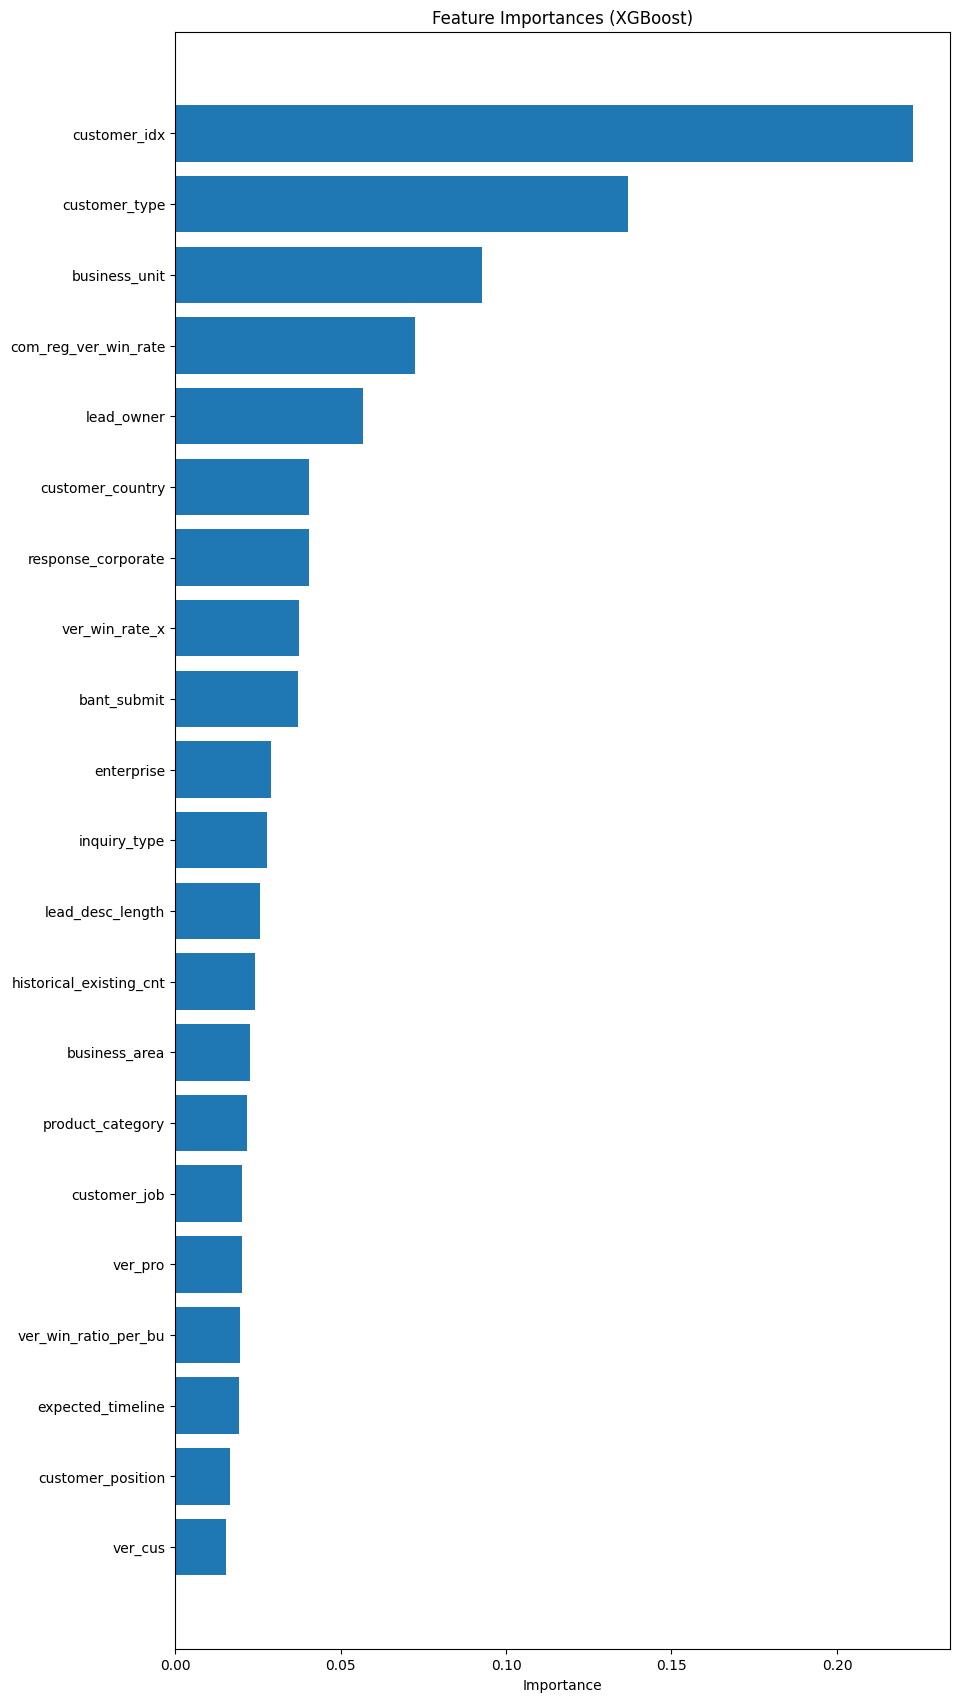

Model Tune for RandomForest.


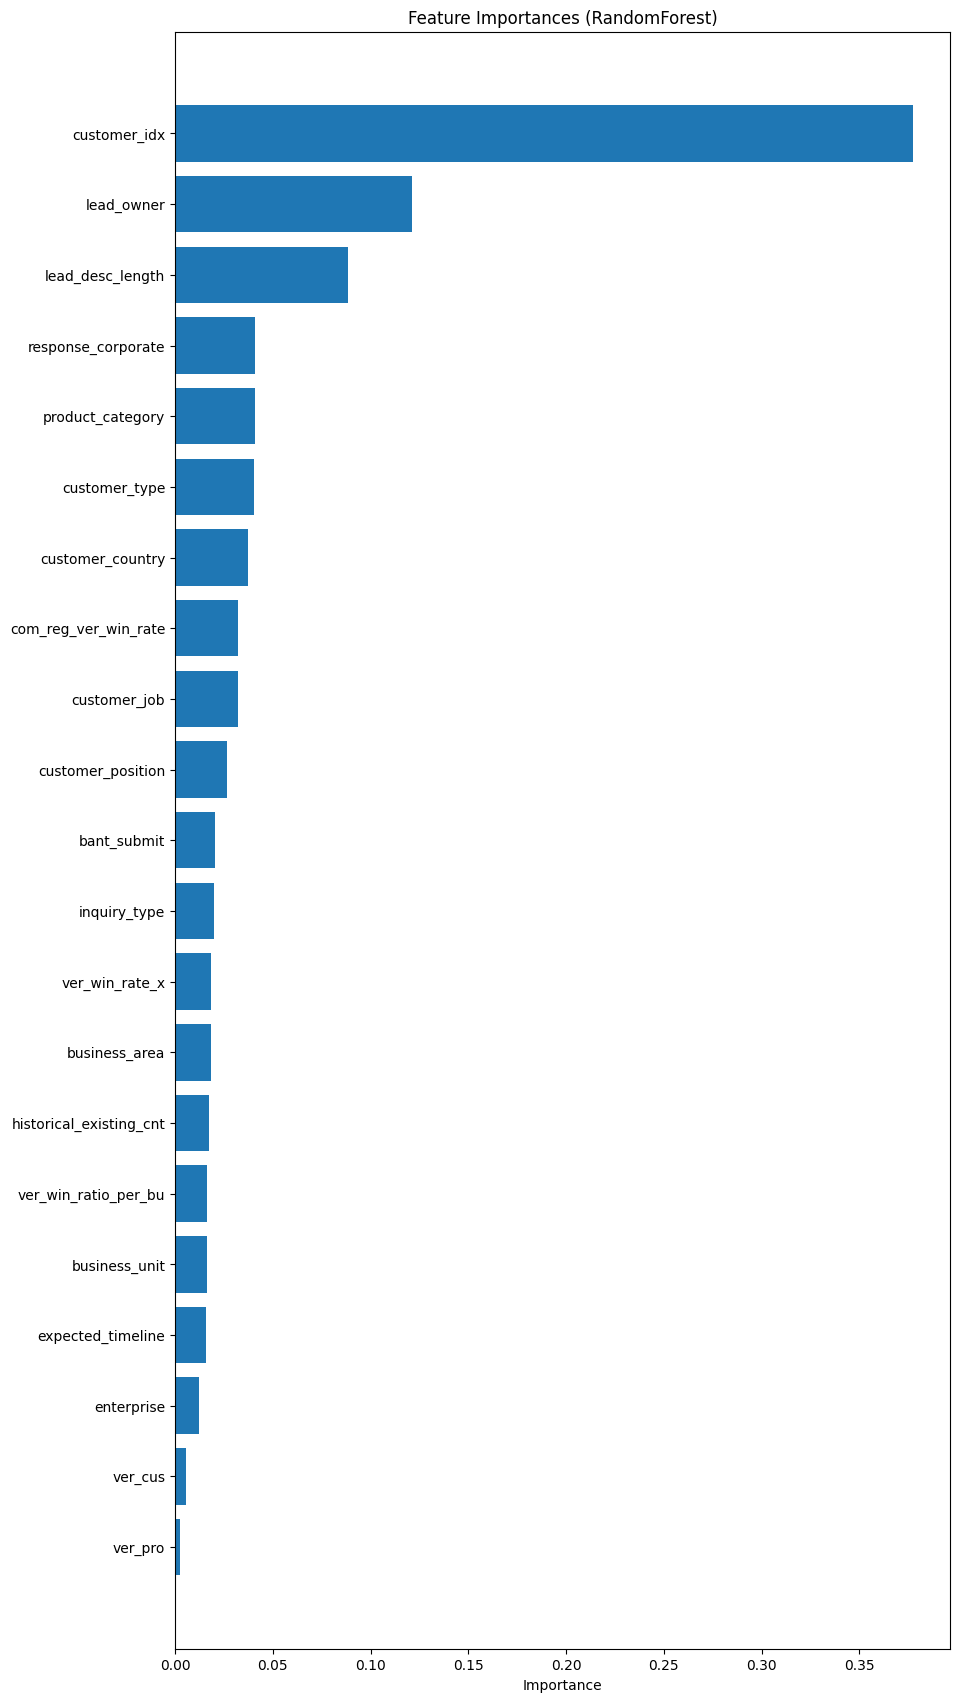

Model Tune for LGBM.
[LightGBM] [Info] Number of positive: 3047, number of negative: 34709
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1886
[LightGBM] [Info] Number of data points in the train set: 37756, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080702 -> initscore=-2.432842
[LightGBM] [Info] Start training from score -2.432842


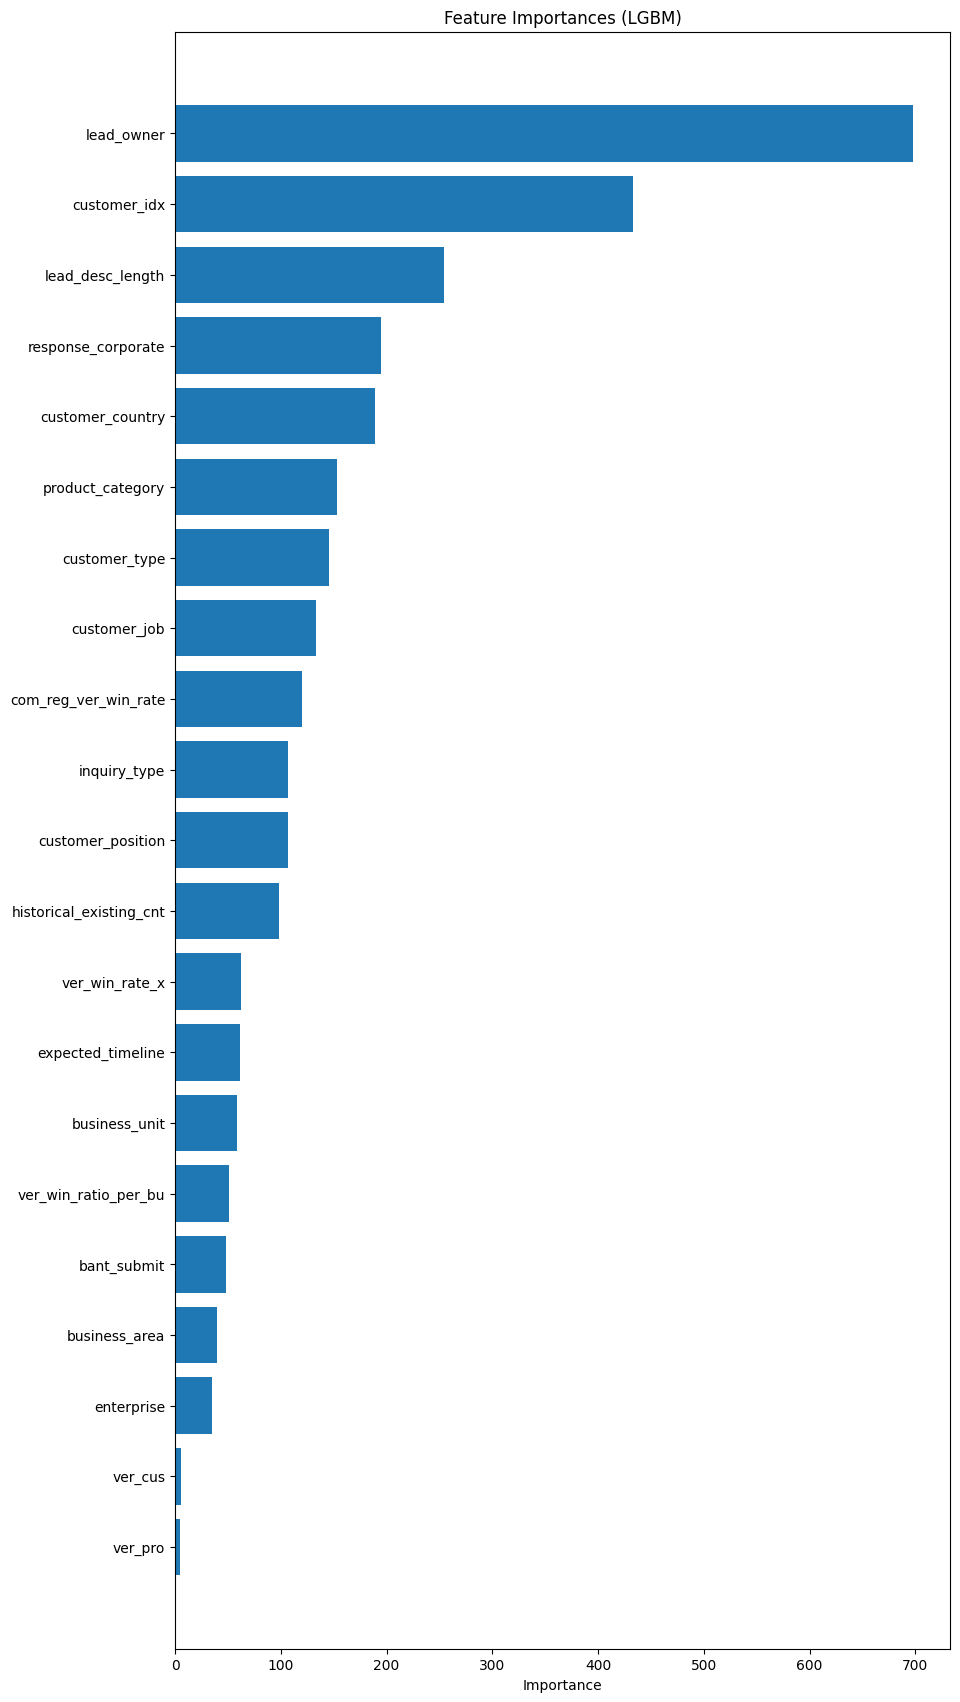

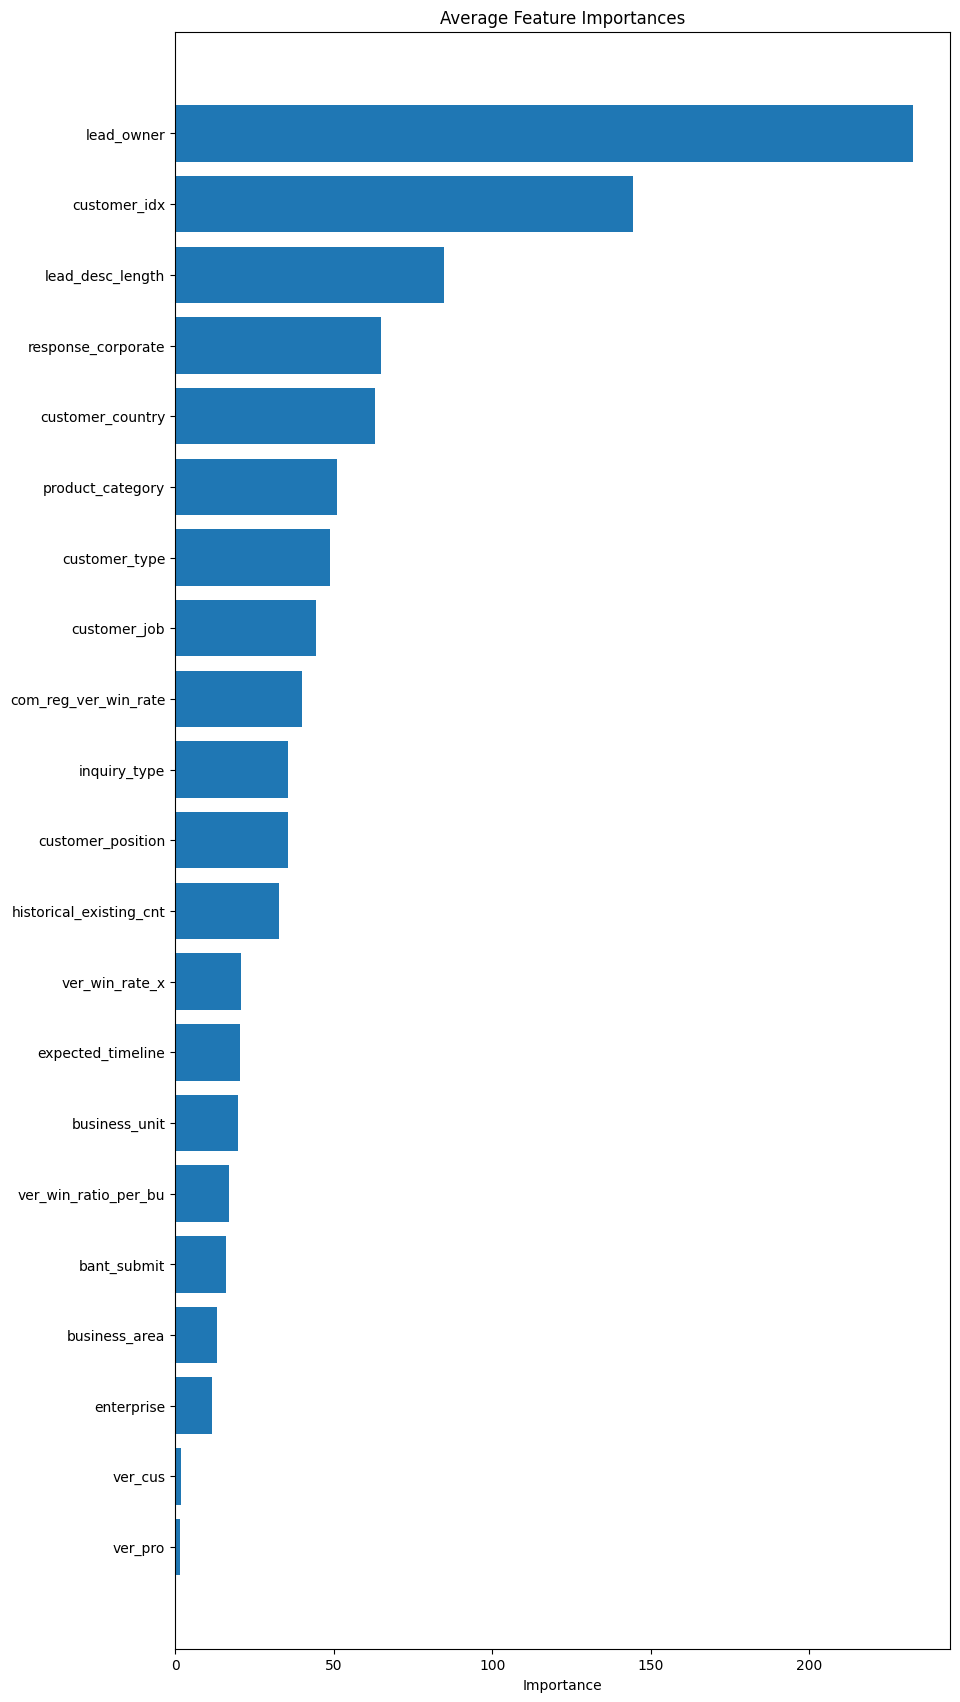

In [60]:
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import numpy as np
import matplotlib.pyplot as plt

def train_and_evaluate(models, model_names, x_train, y_train):
    feature_importances = []

    for model, model_name in zip(models, model_names):
        print(f'Model Tune for {model_name}.')
        model.fit(x_train, y_train)

        #CatBoost의 경우
        if isinstance(model, CatBoostClassifier):
            importances = model.get_feature_importance()
        else:  #그 외 모델의 경우
            importances = model.feature_importances_

        feature_importances.append(importances)

        #개별 모델의 특성 중요도 시각화
        sorted_idx = importances.argsort()
        plt.figure(figsize=(10, x_train.shape[1]))
        plt.title(f"Feature Importances ({model_name})")
        plt.barh(range(x_train.shape[1]), importances[sorted_idx], align='center')
        plt.yticks(range(x_train.shape[1]), x_train.columns[sorted_idx])
        plt.xlabel('Importance')
        plt.show()

    #모든 모델의 특성 중요도를 평균내어 최종 특성 중요도 계산
    avg_feature_importance = np.mean(feature_importances, axis=0)

    return models, avg_feature_importance

# 모델 초기화
models = [
    XGBClassifier(random_state=400),
    RandomForestClassifier(random_state=400),
    LGBMClassifier(random_state=400)
]

model_names = ['XGBoost', 'RandomForest', 'LGBM']

#모델 학습 및 특성 중요도 도출
trained_models, avg_feature_importance = train_and_evaluate(models, model_names, x_train, y_train)

#평균 특성 중요도 시각화
sorted_idx = avg_feature_importance.argsort()
plt.figure(figsize=(10, x_train.shape[1]))
plt.title("Average Feature Importances")
plt.barh(range(x_train.shape[1]), avg_feature_importance[sorted_idx], align='center')
plt.yticks(range(x_train.shape[1]), x_train.columns[sorted_idx])
plt.xlabel('Importance')
plt.show()

In [61]:
#feature importances를 정렬 및 상위 n개의 인덱스 추출
top_5_idx = np.argsort(avg_feature_importance)[-5:]
top_5_features = x_train.columns[top_5_idx]

#train, test, val을 상위 n개 특성만으로 축소
x_train_reduced = x_train[top_5_features]
x_val_reduced = x_val[top_5_features]
x_test_reduced = df_test[top_5_features]

##모델 학습

### Random Forest classification



In [69]:
#RandomForest Classifier 코드

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np
from sklearn.model_selection import StratifiedKFold



#각 fold의 F1 점수를 저장하기 위한 리스트
f1_scores = []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#교차 검증 수행
for train_index, test_index in skf.split(x_train_reduced, y_train):
    #분할된 훈련 및 검증 데이터셋 생성
    X_train_fold, X_val_fold = x_train_reduced.iloc[train_index], x_train_reduced.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    #모델 생성
    model = RandomForestClassifier(random_state = 42, verbose = False)

    model.fit(X_train_fold, y_train_fold)

    val_pred = model.predict(X_val_fold)

    f1 = f1_score(y_val_fold, val_pred, average='binary')
    f1_scores.append(f1)

avg_f1_score = np.mean(f1_scores)
print("KFold 교차 검증을 통한 평균 F1 점수:", avg_f1_score)

KFold 교차 검증을 통한 평균 F1 점수: 0.7764201562100083


###모델 학습

In [63]:
model.fit(x_train_reduced, y_train)

### 모델 성능 보기

In [70]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [71]:
#검증 데이터셋에 대한 예측을 상위 8개 특성으로 축소된 데이터셋을 사용하여 수행
pred = model.predict(x_val_reduced)

#성능 평가 함수 호출
get_clf_eval(y_val, pred)

오차행렬:
 [[14781    95]
 [  388   918]]

정확도: 0.9702
정밀도: 0.9062
재현율: 0.7029
F1: 0.7917


### 테스트 데이터 예측

In [ ]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [ ]:
test_pred = model.predict(x_test_reduced)

#True로 예측된 개수 계산
true_pred_count = sum(test_pred)
print("True로 예측된 개수:", true_pred_count)

True로 예측된 개수: 414
